In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import obspy as op
from salvus import namespace as sn
from obspy.imaging.beachball import beach
from obspy.geodetics.base import gps2dist_azimuth

sp = sn.Project(path="CANV_FULL")
wus = sn.Project(path='CANV256')
cs = sn.Project(path='/Users/claired/Desktop/CANV_CSEM')

Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

In [58]:
wus.events.list()

['event_BAJA_CALIFORNIA_MEXICO_Mag_4.85_2010-04-15-10-20',
 'event_BAJA_CALIFORNIA_MEXICO_Mag_4.86_2010-09-20-00-30',
 'event_BAJA_CALIFORNIA_MEXICO_Mag_5.02_2015-02-09-01-45',
 'event_BAJA_CALIFORNIA_MEXICO_Mag_5.03_2010-09-14-10-52',
 'event_BAJA_CALIFORNIA_MEXICO_Mag_5.15_2011-02-18-17-47',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.82_2012-07-01-03-25',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.84_2008-02-20-01-28',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.84_2010-12-11-12-52',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.85_2012-07-01-06-36',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.86_2010-05-08-18-46',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.91_2008-02-22-19-31',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.97_2010-05-08-18-33',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_4.98_2010-04-05-13-33',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.01_2020-10-01-00-31',
 'event_CALIF.-BAJA_CALIF._BORDER_REGION_Mag_5.03_2008-02-12-04-32',
 'event_CALIF.-

In [128]:
lat_min = 31.5
lat_max = 43
lon_min = -125.0
lon_max = -114.0

#Wells, NV Event
#event_name = 'event_NEVADA_Mag_6.02_2008-02-21-14-16'

#Lassen Event
event_name = 'event_BAJA_CALIFORNIA_MEXICO_Mag_5.15_2011-02-18-17-47'

#SoCal Event
#event_name = 'event_SOUTHERN_CALIFORNIA_Mag_5.36_2018-04-05-19-29'
# Observed Data
data_processing_config_name = "20_80_seconds"
syn0 = sp.waveforms.get(data_name='PROCESSED_DATA:'+data_processing_config_name, events=event_name)

#SPiRaL Initial Model
#simulation_config_name = 'spiral_20_mesh'
simulation_config_name = sp.inversions.get_simulation_name(
    inverse_problem_configuration= "inversion_1_r2", iteration_id = 13)
syn1 = sp.waveforms.get(data_name=simulation_config_name, events=event_name)

#CANV_WUS
simulation_config_name = wus.inversions.get_simulation_name(
    inverse_problem_configuration= 'inversion_2_fixed', iteration_id = 26)
#simulation_config_name = 'WUS256'
syn2 = wus.waveforms.get(data_name=simulation_config_name, events=event_name)

#CANVAS
#simulation_config_name = 'CSEM'
simulation_config_name = cs.inversions.get_simulation_name(
    inverse_problem_configuration= "inversion_2_r2", iteration_id = 22)
syn3 = cs.waveforms.get(data_name=simulation_config_name, events=event_name)



event = sp.events.get(event_name=event_name)
event.sources[0]._initial_arguments

{'depth_in_m': 12000.0,
 'radius_of_sphere_in_m': 6371000.0,
 'source_time_function': None,
 'rotation_on_input': None,
 'reference_time_utc_string': '2011-02-18T17:47:38.100000Z',
 'side_set_name': 'r1',
 'latitude': 31.907069287826,
 'longitude': -115.06,
 'mrr': -4640000000000000.0,
 'mtt': -5.73e+16,
 'mpp': 6.19e+16,
 'mtp': -1.65e+16,
 'mrp': -2.27e+16,
 'mrt': -1.35e+16}

In [129]:
def create_streams(event, sta_lat, sta_lon, st0, st1, st2, st3, filter_wfs):
    import numpy as np
    import matplotlib.pyplot as plt
    from obspy.core import UTCDateTime
    #import obspy
    """
    Plot data and two sets of synthetic waveforms (3-components)
    Inputs:
        event = Salvus event object
        st0 = data stream
        st1 = 1st synthetic stream, e.g. starting model
        st2 = 2nd synthetic stream, e.g. inversion model
        Assumes the streams are for the same event and receiver and have all 3 components
    """
    
    label0 = 'Data'
    label1 = 'CSEM'
    label2 = 'WUS256'
    label3 = 'SPiRaL'
    max_period = 80
    min_period = 20
    filter_wfs = True
    filter_period = 80
    if filter_wfs:
        max_period = filter_period
    
    eve_meta = event.sources[0]._initial_arguments
    eve_lat = eve_meta['latitude']
    eve_lon = eve_meta['longitude']
    
    azi = gps2dist_azimuth(sta_lat,sta_lon, eve_lat,eve_lon)
    bazi = azi[2]
    
    # Origin time
    origin_time = UTCDateTime(event.sources[0]._initial_arguments['reference_time_utc_string'])
    
    # Interpolate waveforms to common sample_Rate
    target_sps = 2
    st0.interpolate(sampling_rate=target_sps)
    st1.interpolate(sampling_rate=target_sps)
    st2.interpolate(sampling_rate=target_sps)
    st3.interpolate(sampling_rate=target_sps)
    
    # Additional highpass filter
    if filter_wfs:
        st0.filter(type='bandpass', freqmin=1/filter_period, freqmax=1/min_period)
        st1.filter(type='bandpass', freqmin=1/filter_period, freqmax=1/min_period)
        st2.filter(type='bandpass', freqmin=1/filter_period, freqmax=1/min_period)
        st3.filter(type='bandpass', freqmin=1/filter_period, freqmax=1/min_period)
    
    tmax = 600
    
    # Cut waveforms to tmax
    st0 = st0.slice(starttime=origin_time, endtime=origin_time+tmax)
    st1 = st1.slice(starttime=origin_time, endtime=origin_time+tmax)
    st2 = st2.slice(starttime=origin_time, endtime=origin_time+tmax)
    st3 = st3.slice(starttime=origin_time, endtime=origin_time+tmax)
    
    # Arrange order of stream components to ZNE
    st0 = st0.select(component="Z") + st0.select(component="N") + st0.select(component="E")
    st1 = st1.select(component="Z") + st1.select(component="N") + st1.select(component="E")
    st2 = st2.select(component="Z") + st2.select(component="N") + st2.select(component="E")
    st3 = st3.select(component="Z") + st3.select(component="N") + st3.select(component="E")
    # Scale amplitudes from meters to micrometers
    for tr in st0:
        tr.data = tr.data * 1.0e6
        tr.stats.distance = azi[0]
    for tr in st1:
        tr.data = tr.data * 1.0e6
        tr.stats.distance = azi[0]
    for tr in st2:
        tr.data = tr.data * 1.0e6
        tr.stats.distance = azi[0]
    for tr in st3:
        tr.data = tr.data * 1.0e6
        tr.stats.distance = azi[0]
        
    st0.rotate(method = 'NE->RT', back_azimuth = bazi)
    st1.rotate(method = 'NE->RT', back_azimuth = bazi)
    st2.rotate(method = 'NE->RT', back_azimuth = bazi)
    st3.rotate(method = 'NE->RT', back_azimuth = bazi)
    
    
    obs_z.append(st0[0])
    obs_r.append(st0[1])
    obs_t.append(st0[2])
    spiral_z.append(st1[0])
    spiral_r.append(st1[1])
    spiral_t.append(st1[2])
    wus_z.append(st2[0])
    wus_r.append(st2[1])
    wus_t.append(st2[2])
    csem_z.append(st3[0])
    csem_r.append(st3[1])
    csem_t.append(st3[2])

In [130]:
eve_meta = event.sources[0]._initial_arguments
eve_lat = eve_meta['latitude']
eve_lon = eve_meta['longitude']
recs_in_window = {}

for  idx in np.arange(0, len(syn1[0].receiver_name_list), 1):   
    sta = syn1[0].receivers[idx].to_json()
    args = sta['arguments']
    sta_lat = sta_lat = converted_latitude = (
    # This function defaults to the WGS84 ellipsoid but others are possible.
    sn.simple_config.coordinate_system_utils._geocentric_to_elliptic_latitude(
        lat=args['latitude']
    )
)
    sta_lon = args['longitude']
    
    azi = gps2dist_azimuth(sta_lat,sta_lon, eve_lat,eve_lon)
    bazi = azi[2]
    dist = azi[0]/1000
    if dist>1325:
        sncl = str(args['network_code']+'.'+ args['station_code'])
        if sncl in ['BK.HATC','BK.HOPS', 'BK.HUMO', 'BK.JCC', 'BK.MNRC', 'BK.MOD','BK.SUTB','BK.ORV','BK.WDC']:
            pass
        else:
            recs_in_window[sncl] = [sta_lat, sta_lon], azi[0]/1000
        
        
print(recs_in_window)

{'NC.KBO': ([42.212357, -124.225983], 1402.578482281397), 'NC.KEB': ([42.87221100000001, -124.334251], 1466.0525359886224), 'NC.KSXB': ([41.830379, -123.876884], 1351.3629625027709), 'TA.K02D': ([42.695499, -123.665398], 1417.9537475726854), 'TA.K04D': ([42.62459900000001, -121.753502], 1328.2960231810994), 'TA.L02D': ([42.157799, -123.603104], 1366.517000555141)}


In [131]:
spiral_z = op.Stream()
wus_z = op.Stream()
csem_z = op.Stream()
obs_z = op.Stream()

spiral_r = op.Stream()
wus_r = op.Stream()
csem_r = op.Stream()
obs_r = op.Stream()

spiral_t = op.Stream()
wus_t = op.Stream()
csem_t = op.Stream()
obs_t = op.Stream()

sta_lats = []
sta_lons = []

for key, value in recs_in_window.items():
    rec = key
    sta_lat = value[0][0]
    sta_lon = value[0][1]
    
    sta_lats.append(sta_lat)
    sta_lons.append(sta_lon)

    st_data = syn0[0].get_receiver_data(receiver_name=rec, receiver_field='displacement')
    #print(st_data)

    st_sp = syn1[0].get_receiver_data(receiver_name=rec, receiver_field='displacement')
    #print(st_syn1)

    st_wus = syn2[0].get_receiver_data(receiver_name=rec, receiver_field='displacement')
    
    st_csem = syn3[0].get_receiver_data(receiver_name=rec, receiver_field='displacement')
    #print(st_syn2)

    filter_wfs = True
    create_streams(event, sta_lat, sta_lon, st_data, st_sp, st_wus, st_csem, filter_wfs)

In [132]:
print(obs_z)

6 Trace(s) in Stream:
NC.KBO..HHZ  | 2011-02-18T17:47:38.100000Z - 2011-02-18T17:57:38.100000Z | 2.0 Hz, 1201 samples
NC.KEB..HHZ  | 2011-02-18T17:47:38.103700Z - 2011-02-18T17:57:38.103700Z | 2.0 Hz, 1201 samples
NC.KSXB..HHZ | 2011-02-18T17:47:38.107700Z - 2011-02-18T17:57:38.107700Z | 2.0 Hz, 1201 samples
TA.K02D..BHZ | 2011-02-18T17:47:38.100000Z - 2011-02-18T17:57:38.100000Z | 2.0 Hz, 1201 samples
TA.K04D..BHZ | 2011-02-18T17:47:38.100000Z - 2011-02-18T17:57:38.100000Z | 2.0 Hz, 1201 samples
TA.L02D..BHZ | 2011-02-18T17:47:38.100000Z - 2011-02-18T17:57:38.100000Z | 2.0 Hz, 1201 samples


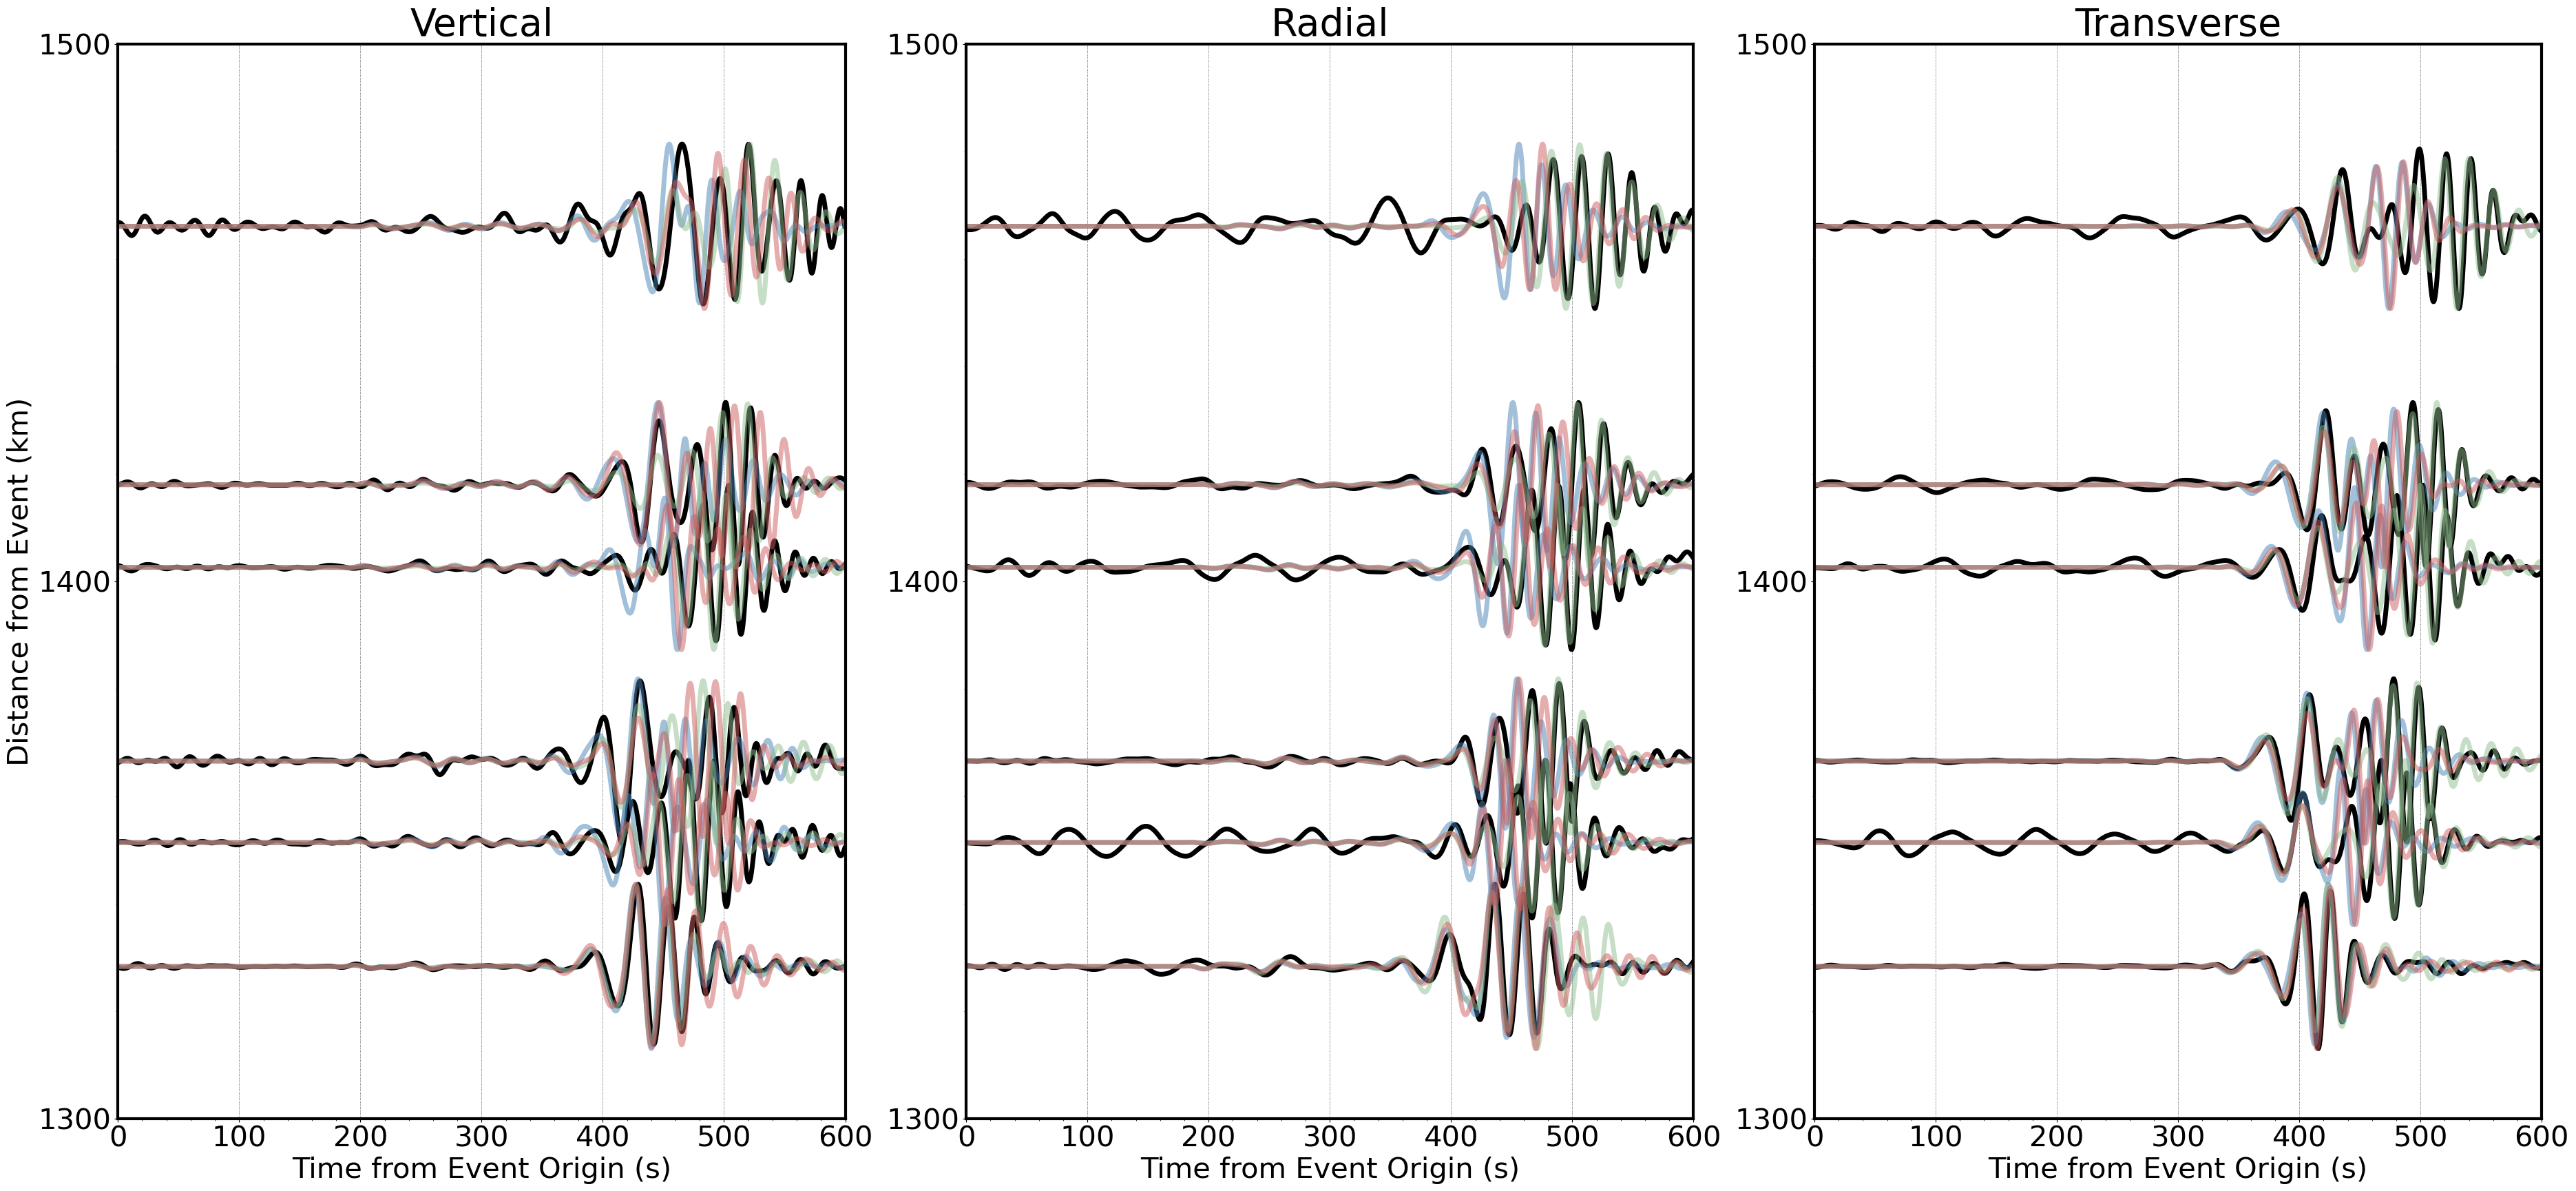

In [133]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

fig,ax = plt.subplots(figsize = (40,20))
#plt.title('Record Section for Wells, NV Event (Stations with backazimuth between 195˚-205˚)', fontsize = 50)
plt.subplot(131)
obs = obs_z.plot(fig=fig, type='section',  color='black', alpha= 1.0, linewidth = 5, label='Observed Data', orientation = 'horizontal', show=False)
spiral= spiral_z.plot(fig=fig, type='section',  color='steelblue', alpha= 0.5, linewidth = 5, label='SPiRaL Model', orientation= 'horizontal', show=False)
wus_awt = wus_z.plot(fig=fig, type='section',  color='darkseagreen', alpha= 0.5, linewidth = 5, label='WUS_AWT Model', orientation= 'horizontal', show=False)
csem = csem_z.plot(fig=fig, type='section',  color='indianred', alpha= 0.5, linewidth = 5, label='CSEM_NA Model', orientation= 'horizontal', show=False)
#canv_wus = canv_wus_z.plot(fig=fig, type='section',  color='g', alpha= 0.5, linewidth = 3, label='CANV_WUS Model', orientation= 'horizontal', show=False)

plt.ylabel('Distance from Event (km)', fontsize = 30)
plt.yticks([1300,1400,1500], fontsize = 30)
plt.ylim([1300,1500])
plt.title('Vertical', fontsize = 40)
plt.xticks([0,100,200,300,400,500,600], fontsize = 30)
plt.xlabel('Time from Event Origin (s)', fontsize = 30)
#plt.ylim([100,275])

mpl.rcParams['axes.linewidth'] = 3
plt.subplot(132)
obs = obs_r.plot(fig=fig, type='section',  color='black', alpha= 1.0, linewidth = 5, label='Observed Data', orientation = 'horizontal', show=False)
spiral= spiral_r.plot(fig=fig, type='section',  color='steelblue',alpha= 0.5, linewidth = 5,label='SPiRaL Model', orientation= 'horizontal', show=False)
wus_awt = wus_r.plot(fig=fig, type='section',  color='darkseagreen', alpha= 0.5, linewidth = 5, label='WUS_AWT Model', orientation= 'horizontal', show=False)
csem = csem_r.plot(fig=fig, type='section',  color='indianred', alpha= 0.5, linewidth = 5, label='CSEM_NA Model', orientation= 'horizontal', show=False)
#canv_wus = canv_wus_r.plot(fig=fig, type='section',  color='g', alpha= 0.5, linewidth = 3, label='CANV_WUS Model', orientation= 'horizontal', show=False)
plt.ylabel('  ')
plt.yticks([])
plt.title('Radial', fontsize = 40)
plt.yticks([1300,1400,1500], fontsize = 30)
plt.ylim([1300,1500])
plt.xticks([0,100,200,300,400,500,600], fontsize = 30)
plt.xlabel('Time from Event Origin (s)', fontsize = 30)
plt.tight_layout()

plt.subplot(133)
obs = obs_t.plot(fig=fig, type='section',  color='black', alpha= 1.0, linewidth = 5, label='Observed Data', orientation = 'horizontal', show=False)
spiral= spiral_t.plot(fig=fig, type='section',  color='steelblue', alpha= 0.5, linewidth = 5, label='SPiRaL Model', orientation= 'horizontal', show=False)
wus_awt = wus_t.plot(fig=fig, type='section',  color='darkseagreen', alpha= 0.5, linewidth = 5, label='WUS_AWT Model', orientation= 'horizontal', show=False)
csem = csem_t.plot(fig=fig, type='section',  color='indianred', alpha= 0.5, linewidth = 5, label='CSEM_NA Model', orientation= 'horizontal', show=False)

plt.ylabel('  ')
plt.yticks([])
plt.title('Transverse', fontsize = 40)
plt.yticks([1300,1400,1500], fontsize = 30)
plt.ylim([1300,1500])
plt.xticks([0,100,200,300,400, 500, 600], fontsize = 30)
plt.xlabel('Time from Event Origin (s)', fontsize = 30)

mpl.rcParams['axes.linewidth'] = 1
plt.savefig('Baja_5.15_Record Section_final.png')
#plt.show()

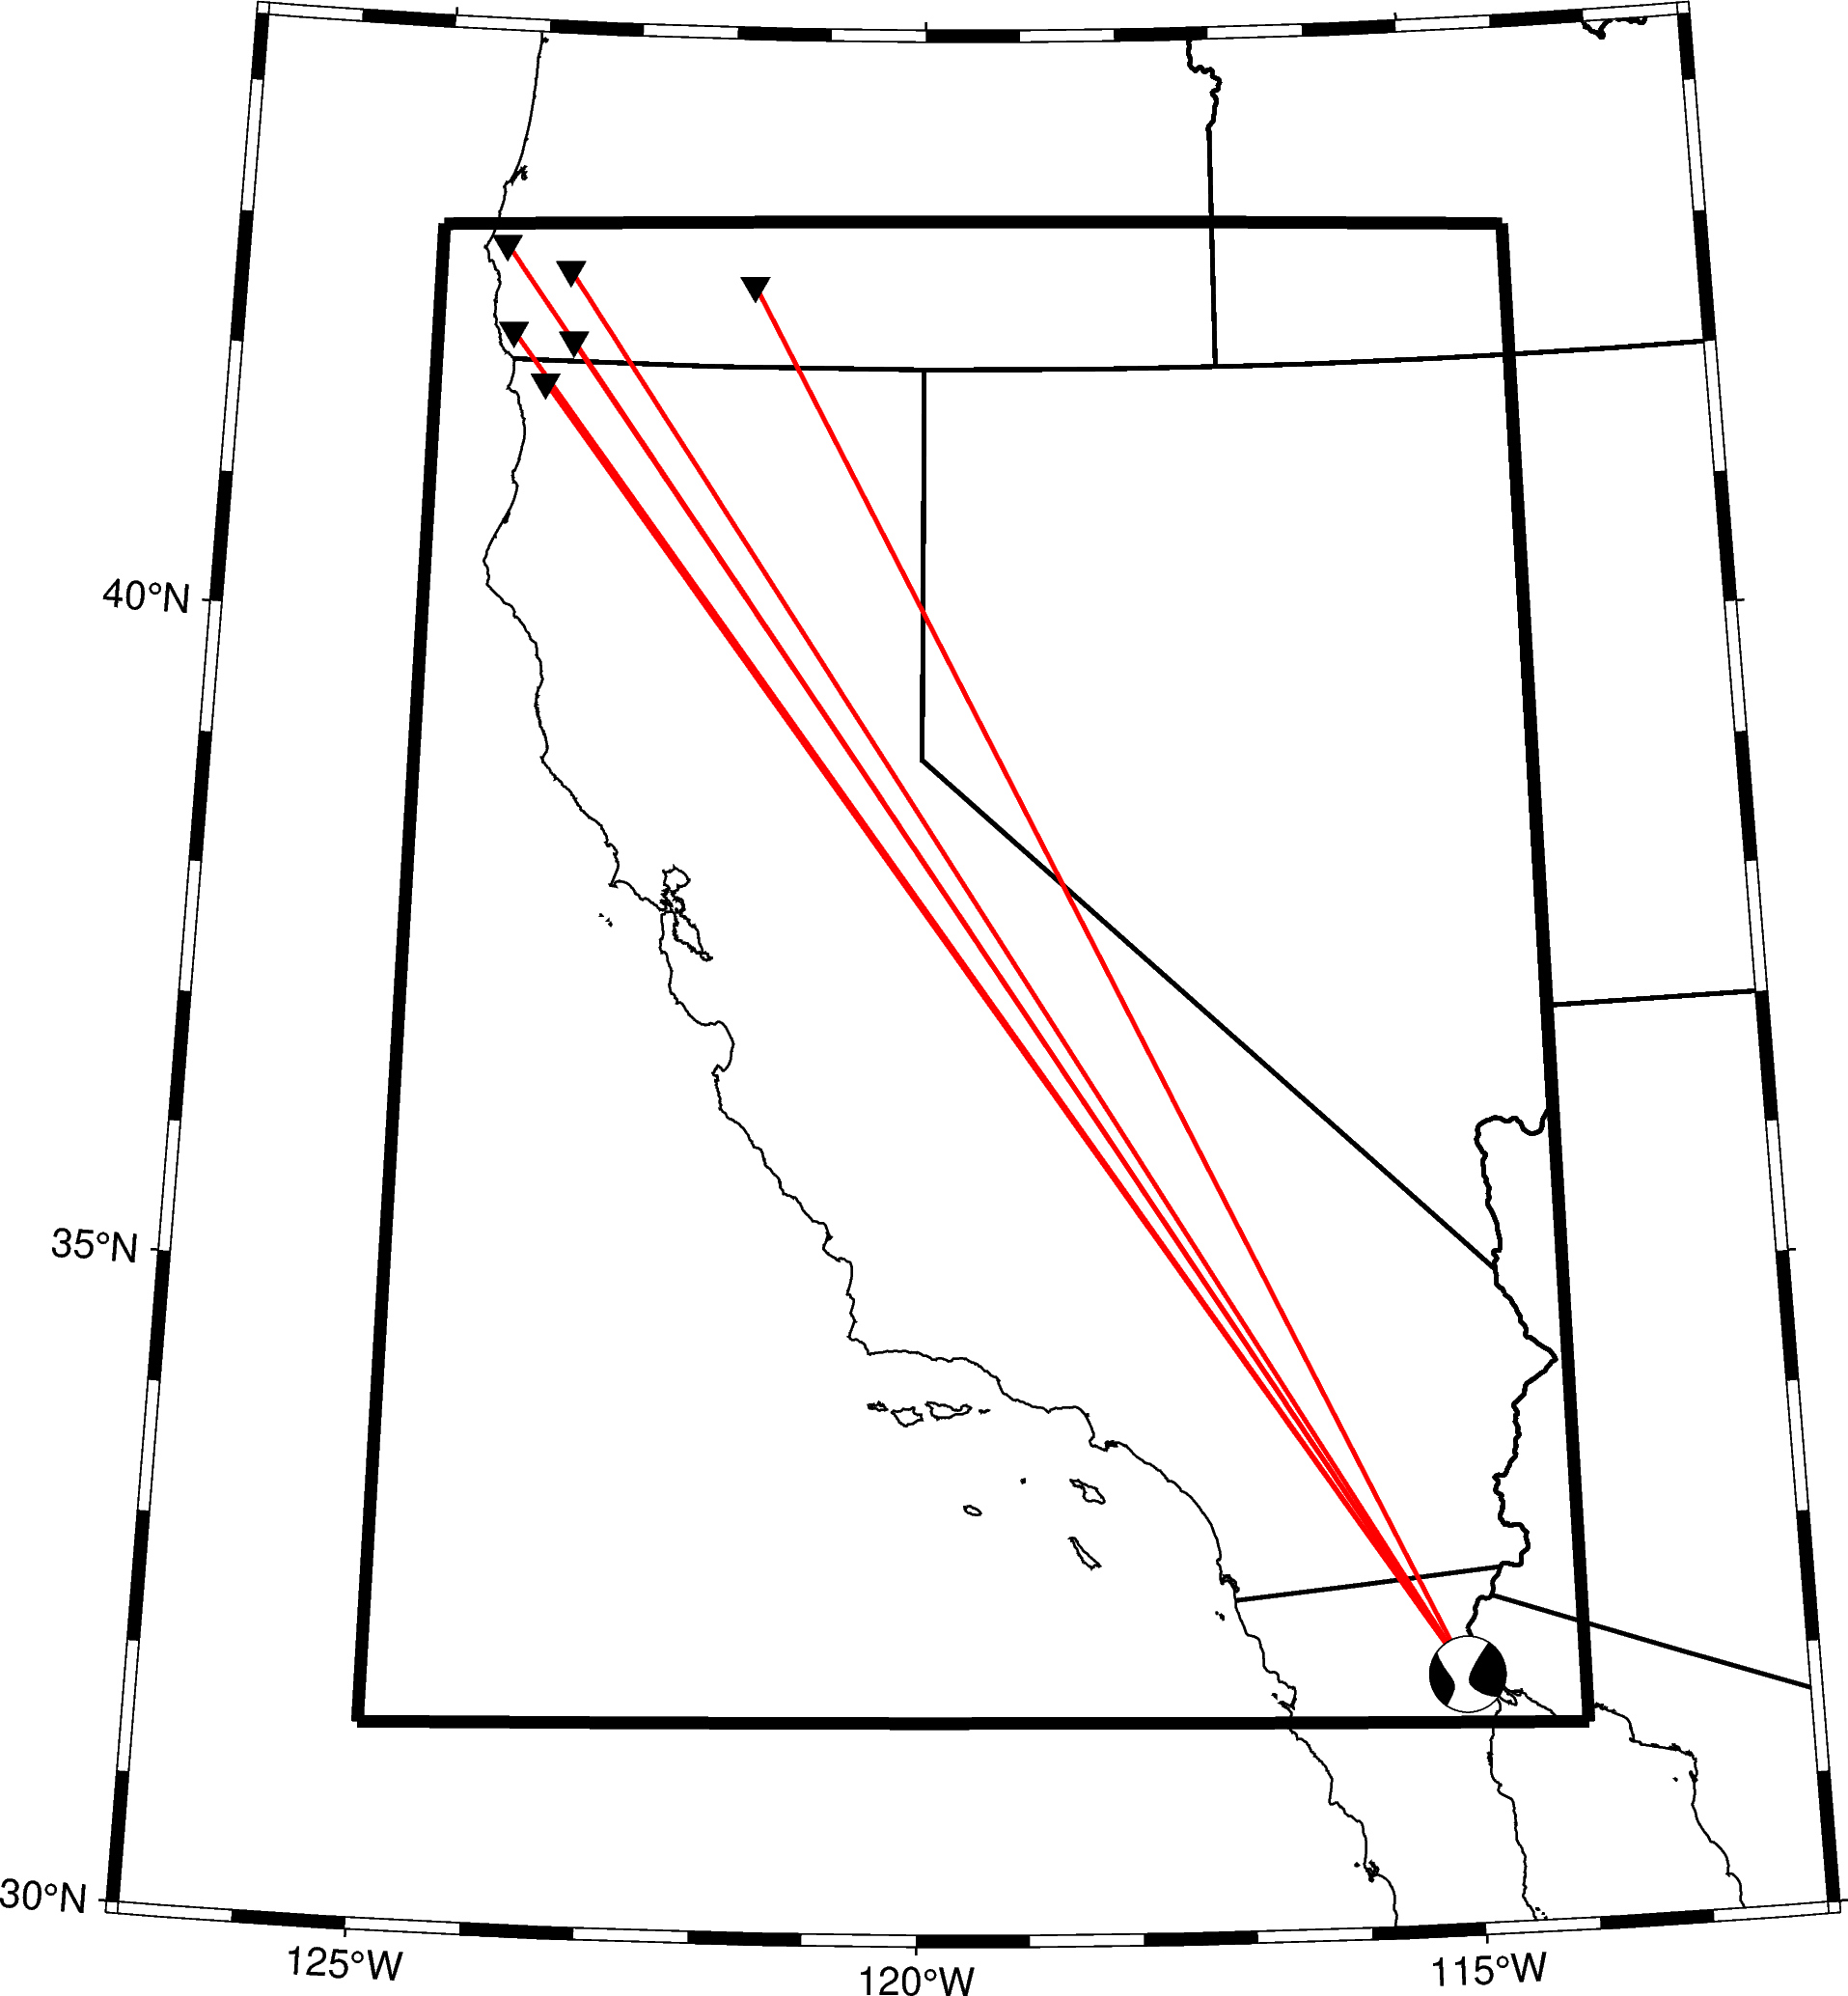

In [96]:
import pygmt

fig = pygmt.Figure()

event = wus.events.get(event_name=event_name)
eve_meta = event.sources[0]._initial_arguments

fig.coast(shorelines = '1/0.5p', region = [-127,-112,30,44.5], projection='L-119.5/37.25/30/44.5/15c',
            frame = 'af', borders=["1/thick,black", "2/thick,black"])
#fig.colorbar(frame=["a1000", "x+lElevation", "y+lm"])

fig.plot(region = [-127,-112,30,44.5], projection='L-119.5/37.25/30/44.5/15c',
        frame = None, x = [-125,-114], y = [31.5,31.5], pen="3p,black")
fig.plot(region = [-127,-112,30,44.5], projection='L-119.5/37.25/30/44.5/15c',
        frame = None, x =[-125,-114] , y = [43,43], pen="3p,black")

fig.plot(region = [-127,-112,30,44.5], projection='L-119.5/37.25/30/44.5/15c',
        frame = None, x = [-125,-125], y = [31.5,43], pen="3p,black")
fig.plot(region = [-127,-112,30,44.5], projection='L-119.5/37.25/30/44.5/15c',
        frame = None, x = [-114,-114], y = [31.5,43], pen="3p,black")

for i in range(0, len(sta_lats) ):
    fig.plot(region = [-127,-112,30,44.5], projection='L-119.5/37.25/30/44.5/15c',
            frame = None, x = [eve_meta['longitude'],sta_lons[i]], 
             y = [eve_meta['latitude'],sta_lats[i]], pen="1p,red")


fig.plot(x = sta_lons, y = sta_lats, style="i0.3c",color = 'black')

mt = {'mrr': eve_meta['mrr'], 'mtt': eve_meta['mtt'],'mff':eve_meta['mpp'],
          'mrt': eve_meta['mrt'], 'mrf': eve_meta['mrp'], 'mtf':eve_meta['mtp'], 'exponent':16}
fig.meca(mt, scale="0.3c", longitude=eve_meta['longitude'], 
         latitude=eve_meta['latitude'], depth=eve_meta['depth_in_m']/1000.)

fig.show()

In [97]:
fig.savefig('Baja_5.15_Inset_Map.jpg')